# Estimate car price - Impute data and train Machine Learning model
This notebook is part of a Machine Learning project that is described and available to download on 
<BR><a href="https://blogs.sap.com/2019/11/05/hands-on-tutorial-machine-learning-push-down-to-sap-hana-with-python/">https://blogs.sap.com/2019/11/05/hands-on-tutorial-machine-learning-push-down-to-sap-hana-with-python/</a>
<BR><BR>The purpose of this notebook is to deal with missing values in the dataset and to train a Machine Learning model that can predict a car's price.

### Steps in this notebook
-  Connect to SAP HANA
-  Create a SAP HANA DataFrame which points to the data
-  Deal with missing values, mostly by replacing a missing value with the column average
-  Train and improve a Machine Learning model
-  Carry out an error analysis to understand in which areas the model performed better or worse.

### Documentation
-  SAP HANA Python Client API for Machine Learning Algorithms:   
   https://help.sap.com/doc/0172e3957b5946da85d3fde85ee8f33d/latest/en-US/html/hana_ml.html
-  SAP HANA Predictive Analysis Library (PAL):  
   https://help.sap.com/viewer/2cfbc5cf2bc14f028cfbe2a2bba60a50/latest/en-US/f652a8186a144e929a1ade7a3cb7abe8.html
-  Dataset: https://www.kaggle.com/bozungu/ebay-used-car-sales-data

### Create a SAP HANA DataFrame, which points to the training data
Instantiate a connecton object to SAP HANA.
-  For simplicity, to help you get started, these values are hardcoded here. 
-  We recommend keeping these credentials in the Secure User Store of the SAP HANA Client. Retrieving the credentials from the Secure User Store prevents having to specify these credentials in clear text. See the blog on the SAP Commmunity to which these notebooks belong, for steps on how to use that Secure User Store.

In [1]:
import hana_ml.dataframe as dataframe
conn = dataframe.ConnectionContext(userkey = 'hana_hxe', encrypt = 'true', sslValidateCertificate = 'false')

Create the SAP HANA DataFrame, which points to the view with historic sales. No data is extracted.

In [2]:
df_remote_history = conn.table(table = 'USEDCARPRICES_TOTRAIN').sort("CAR_ID", desc = False )

### Display some of the rows with missing data
The descriptive statistics in the earlier notebook showed that some columns contain missing values. Show some of the rows in which the information about the GEARBOX is missing. The missing value is shown as "None".

In [3]:
df_remote_history.filter('GEARBOX IS NULL').head(5).collect()

,CAR_ID,VEHICLETYPE,YEAR,GEARBOX,HP,MODEL,KILOMETER,FUELTYPE,PRICE
0,170,limousine,2000,None,82,A-Class,150000,petrol,1299.0
1,192,suv,2007,None,306,M-Class,150000,diesel,16500.0
2,249,coupe,2004,None,0,C-Class,100000,petrol,4450.0
3,250,limousine,2009,None,0,A-Class,50000,petrol,8100.0
4,268,kombi,2002,None,0,E-Class,150000,diesel,1800.0


### Impute missing values  
Impute numerical columns with their average value and categorical columns with their most frequent value. For the GEARBOX column replace missing values with the term "Gearbox unknown".

In [4]:
from hana_ml.algorithms.pal.preprocessing import Imputer
impute = Imputer(strategy = 'mean')
df_remote_imp = impute.fit_transform(data = df_remote_history,
                                     strategy_by_col = [('GEARBOX', 'categorical_const', 'Gearbox unknown')])

The descriptive statistics for the imputed SAP HANA Data Frame correctly show, that no columns contain null values anymore.

In [5]:
df_remote_imp.describe().collect()

,column,count,unique,nulls,mean,std,min,max,median,25_percent_cont,25_percent_disc,50_percent_cont,50_percent_disc,75_percent_cont,75_percent_disc
0,CAR_ID,19800,19800,0,13453.572980,7770.315293,0.0,26899.0,13504.0,6711.75,6711.0,13503.5,13503.0,20161.25,20161.0
1,YEAR,19800,22,0,2006.343939,34.956677,2000.0,6200.0,2005.0,2002.00,2002.0,2005.0,2005.0,2009.00,2009.0
2,HP,19800,257,0,167.690303,126.374861,0.0,13636.0,163.0,122.00,122.0,163.0,163.0,204.00,204.0
3,KILOMETER,19800,13,0,125879.292929,38388.672308,5000.0,150000.0,150000.0,100000.00,100000.0,150000.0,150000.0,150000.00,150000.0
4,PRICE,19800,1694,0,10594.877879,8743.525019,0.0,49999.0,7777.0,4000.00,4000.0,7777.0,7777.0,14900.00,14900.0
5,VEHICLETYPE,19800,8,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,GEARBOX,19800,3,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,MODEL,19800,18,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,FUELTYPE,19800,7,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


To understand the imputation behaviour, investigate how the FUELTYPE was imputed. The number of missing values that were imputed and the replacement value are shown.

In [6]:
col_name = 'FUELTYPE'
len_col_name = str(len(col_name))
impute.stats_model_.filter('LEFT(STAT_NAME, ' + len_col_name + ') = \'' + col_name +  '\'').collect()

,STAT_NAME,STAT_VALUE
0,FUELTYPE.NUMBER_OF_NULLS,703
1,FUELTYPE.IMPUTATION_TYPE,MODE
2,FUELTYPE.IMPUTED_VALUE,diesel


Verify how one of the original rows with missing GEARBOX has been imputed

In [7]:
df_remote_imp.filter('CAR_ID = 2412').collect()

,CAR_ID,VEHICLETYPE,YEAR,GEARBOX,HP,MODEL,KILOMETER,FUELTYPE,PRICE
0,2412,limousine,2000,Gearbox unknown,163,C-Class,150000,petrol,2999.0


### Split dataset
Split the data into two separate subsets. One subset will be used to train different models. The other subset will be used to test the quality of the models.

In [8]:
from hana_ml.algorithms.pal import partition
df_remote_train, df_remote_test, df_remote_ignore = partition.train_test_val_split(random_seed = 1972,
                                                                                   data = df_remote_imp, 
                                                                                   training_percentage = 0.7, 
                                                                                   testing_percentage = 0.3,
                                                                                   validation_percentage = 0)

In [9]:
print('Size of training subset: ' + str(df_remote_train.count()))
print('Size of test subset: ' + str(df_remote_test.count()))

Size of training subset: 13860
Size of test subset: 5940


### Train decision tree regression
Train a first model to estimate the price

In [10]:
from hana_ml.algorithms.pal import trees
tree_reg = trees.DecisionTreeRegressor(algorithm = 'cart',
                                       min_records_of_parent = 10,
                                       min_records_of_leaf = 1,
                                       thread_ratio = 0.4,
                                       split_threshold = 1e-5,
                                       model_format = 'json',
                                       output_rules = True)

# Specify the tree's predictors
features = ['GEARBOX', 'VEHICLETYPE', 'YEAR', 'MODEL', 'HP', 'FUELTYPE', 'KILOMETER']

# Train the tree
tree_reg.fit(data = df_remote_train,
             key = 'CAR_ID', 
             label = 'PRICE', 
             features = features)

### Show decision tree logic 
Display a small element of the whole tree's logic. The first branch of the tree:

In [11]:
df_rules = tree_reg.decision_rules_.head(1).collect()
df_rules.iloc[0,1]

'(YEAR<2006.5) && (HP<222.5) && (YEAR>=2003.5) && ((MODEL=M-Class)||(MODEL=S-Class)||(MODEL=CLK)||(MODEL=Viano)||(MODEL=SLK)||(MODEL=SL)||(MODEL=G-Class)) && ((MODEL=SL)||(MODEL=G-Class)) => 24350'

### Quality assessment on training data
Calculate R^2, the coefficient of determination.

In [12]:
print('R^2 on training data: ' + str(round(tree_reg.score(data = df_remote_train,
                                                          key = 'CAR_ID'), 3)))

R^2 on training data: 0.94


### Quality assessment on test data
First compare the estimated value with the true value for a small number of cars.

In [13]:
df_remote_act_pred = df_remote_test.alias('L').join(
    tree_reg.predict(data = df_remote_test, features = features, key = 'CAR_ID').alias('R'),
    'L.CAR_ID = R.CAR_ID', 
    select=[('L.CAR_ID', 'CAR_ID'), 'MODEL', ('PRICE','ACTUALS'), ('SCORE', 'PREDICTIONS')])

In [14]:
df_remote_act_pred.head(5).collect()

,CAR_ID,MODEL,ACTUALS,PREDICTIONS
0,6,Vito,1400.0,3485.66
1,7,Sprinter,5000.0,5516.5
2,25,M-Class,27500.0,20971.5
3,28,Other,11700.0,11102.3
4,35,A-Class,2990.0,2493.59


The underlying SELECT statement was automatically created to produce the above table.

In [15]:
df_remote_act_pred.select_statement

'SELECT L.CAR_ID AS "CAR_ID", "MODEL", PRICE AS "ACTUALS", SCORE AS "PREDICTIONS" FROM (SELECT a.* FROM #PAL_PARTITION_DATA_TBL_27A985B6_5736_11EB_9A41_D43B0469E0D7 a inner join #PAL_PARTITION_RESULT_TBL_27A985B6_5736_11EB_9A41_D43B0469E0D7 b        on a."CAR_ID" = b."CAR_ID" where b."PARTITION_TYPE" = 2) AS "L" INNER JOIN (SELECT * FROM "#PAL_DECISION_TREE_RESULT_TBL_1_2C7FC880_5736_11EB_8252_D43B0469E0D7") AS "R" ON L.CAR_ID = R.CAR_ID'

Assess the performance of the model on the unseen test data with the Root Mean Squared Error (RMSE). Again, the heavy calculations are done within SAP HANA. The RMSE can be understood as an "average" mistake in the unit of the target column. So the model was roughly off by 3500 Euros per vehicle.

In [16]:
import numpy as np
df_remote_se = df_remote_act_pred.select('CAR_ID',
                                         'MODEL',
                                         'ACTUALS',
                                         'PREDICTIONS',
                                         ('(ACTUALS - PREDICTIONS) * (ACTUALS - PREDICTIONS) ', 'ERRORSQ'))
df_mse = df_remote_se.agg([('avg', 'ERRORSQ', 'MSE')]).collect()
rmse = np.sqrt(float(df_mse.iloc[0:,0]))
print('RMSE: ' + str(round(rmse, 2)))

RMSE: 3537.11


### Hyperparameter tuning
Try out different combinations of model parameters in the hope of finding a stronger model. For each model that is trained, the RMSE is calculated and kept for later analysis.

In [17]:
min_records_of_parent = [1, 2, 3, 4, 5, 7, 10]
min_records_of_leaf = [1, 2, 3, 5]

Install the sklearn library that will be needed to calculate the quality indicator of the model, the Room Mean Squared Error. 
<BR>Once the library is installed, the command can be de-activated by adding a # in front. This character turns the code into a comment.

In [18]:
!pip install sklearn

In [19]:
import pandas as pd
from math import sqrt
from sklearn.metrics import mean_squared_error

# Dataframe to store hyperparameters with model quality
df_hyper_quality = pd.DataFrame(columns=['MIN_RECORDS_OF_PARENT', 'MIN_RECORDS_OF_LEAF', 'RMSE'])

# Iterate through all combinations
from hana_ml.algorithms.pal import trees
for aa in min_records_of_parent:
    for bb in min_records_of_leaf:
        tree_reg = trees.DecisionTreeRegressor(algorithm = 'cart',
                                               min_records_of_parent = aa,
                                               min_records_of_leaf = bb,
                                               thread_ratio = 0.4,
                                               split_threshold = 1e-5,
                                               model_format = 'json',
                                               output_rules = True)

        # Train the tree
        tree_reg.fit(data = df_remote_train, 
                     features = features, 
                     key = "CAR_ID", 
                     label = 'PRICE')

        print('min_records_of_parent: ', aa, ' | min_records_of_leaf: ', bb)
        
        df_remote_act_pred = df_remote_test.alias('L').join(
            tree_reg.predict(data = df_remote_test, features = features, key = 'CAR_ID').alias('R'),
            'L.CAR_ID = R.CAR_ID', 
            select=[('L.CAR_ID', 'CAR_ID'), ('PRICE','ACTUALS'), ('"SCORE"', 'PREDICTIONS')])
        df_act_pred = df_remote_act_pred.select('ACTUALS', 'PREDICTIONS').collect()
        rmse = sqrt(mean_squared_error(df_act_pred.loc[:,'ACTUALS'], df_act_pred.loc[:,'PREDICTIONS']))
        print('RMSE on test data: ' + str(round(rmse, 2)))
        print()
        
        # Add to hyperparameter store
        df_hyper_quality = df_hyper_quality.append({'MIN_RECORDS_OF_PARENT': aa,
                                                    'MIN_RECORDS_OF_LEAF': bb,
                                                    'RMSE': rmse},
                                                    ignore_index = True)
        
print('Done')

min_records_of_parent:  1  | min_records_of_leaf:  1
RMSE on test data: 3591.83

min_records_of_parent:  1  | min_records_of_leaf:  2
RMSE on test data: 3497.65

min_records_of_parent:  1  | min_records_of_leaf:  3
RMSE on test data: 3449.46

min_records_of_parent:  1  | min_records_of_leaf:  5
RMSE on test data: 3408.44

min_records_of_parent:  2  | min_records_of_leaf:  1
RMSE on test data: 3591.83

min_records_of_parent:  2  | min_records_of_leaf:  2
RMSE on test data: 3497.65

min_records_of_parent:  2  | min_records_of_leaf:  3
RMSE on test data: 3449.46

min_records_of_parent:  2  | min_records_of_leaf:  5
RMSE on test data: 3408.44

min_records_of_parent:  3  | min_records_of_leaf:  1
RMSE on test data: 3601.37

min_records_of_parent:  3  | min_records_of_leaf:  2
RMSE on test data: 3497.65

min_records_of_parent:  3  | min_records_of_leaf:  3
RMSE on test data: 3449.46

min_records_of_parent:  3  | min_records_of_leaf:  5
RMSE on test data: 3408.44

min_records_of_parent:  4  |

### Model quality by hyperparameters
Display the models with the lowest RMSE.

In [20]:
df_hyper_quality['MIN_RECORDS_OF_PARENT'] = df_hyper_quality['MIN_RECORDS_OF_PARENT'].astype(int)
df_hyper_quality['MIN_RECORDS_OF_LEAF'] = df_hyper_quality['MIN_RECORDS_OF_LEAF'].astype(int)
df_hyper_quality.sort_values(by = 'RMSE', ascending = True).head(10)

,MIN_RECORDS_OF_PARENT,MIN_RECORDS_OF_LEAF,RMSE
27,10,5,3408.440068
3,1,5,3408.440068
23,7,5,3408.440068
7,2,5,3408.440068
15,4,5,3408.440068
19,5,5,3408.440068
11,3,5,3408.440068
26,10,3,3448.069412
2,1,3,3449.460618
6,2,3,3449.460618


Plot the RMSE of the different models and their parameters to understand which areas of hyperparameters were most promising.

In [21]:
df_hyper_matrix = df_hyper_quality.pivot(index = 'MIN_RECORDS_OF_PARENT', 
                                         columns = 'MIN_RECORDS_OF_LEAF', 
                                         values = 'RMSE')
df_hyper_matrix = df_hyper_matrix.sort_index(axis = 0, ascending = False)

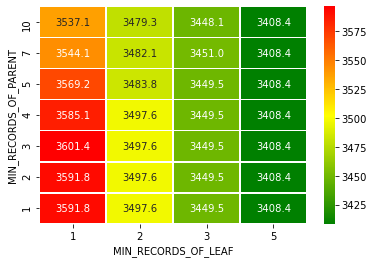

In [22]:
%matplotlib inline
import seaborn as sns
import matplotlib 
traffic_light = matplotlib.colors.LinearSegmentedColormap.from_list('', ['green', 'yellow', 'red'])
sns.heatmap(data = df_hyper_matrix, cmap = traffic_light, linewidths = .5, 
           robust = True, annot = True, fmt = ".1f", xticklabels = df_hyper_matrix.columns.values.round(2));

Models with MIN_RECORDS_OF_LEAF equal to 5 performed well. You could try testing models with larger values of MIN_RECORDS_OF_PARENT to get an even better model.
<BR><BR>In this project however, we are satisfied for now with the lowest RMSE that was found (MIN_RECORDS_OF_PARENT = 10 and MIN_RECORDS_OF_LEAF = 5). We recreate that model and continue the project with it.

In [23]:
from hana_ml.algorithms.pal import trees
tree_reg = trees.DecisionTreeRegressor(algorithm = 'cart',
                                       min_records_of_parent= 10,
                                       min_records_of_leaf = 5,
                                       thread_ratio = 0.4,
                                       split_threshold = 1e-5,
                                       model_format = 'json',
                                       output_rules = True)

# Specify the tree's predictors
features = ['GEARBOX', 'VEHICLETYPE', 'YEAR', 'MODEL', 'HP', 'FUELTYPE', 'KILOMETER']

# Train the tree
tree_reg.fit(data = df_remote_train,
             key = 'CAR_ID',
             label = 'PRICE',
             features = features)

Verify that the model was created correctly. You should obtain the same RMSE as shown in the above plot.

In [24]:
df_remote_act_pred = df_remote_test.alias('L').join(
    tree_reg.predict(data = df_remote_test, features = features, key = 'CAR_ID').alias('R'),
    'L.CAR_ID = R.CAR_ID', 
    select=[('L.CAR_ID', 'CAR_ID'), 'MODEL', ('PRICE','ACTUALS'), ('SCORE', 'PREDICTIONS')])

In [25]:
df_remote_se = df_remote_act_pred.select('CAR_ID',
                                         'MODEL', 
                                         'ACTUALS', 
                                         'PREDICTIONS', 
                                         ('(ACTUALS - PREDICTIONS) * (ACTUALS - PREDICTIONS) ', 'ERRORSQ'))
df_mse = df_remote_se.agg([('avg', 'ERRORSQ', 'MSE')]).collect()
rmse = np.sqrt(float(df_mse.iloc[0:,0]))
print('RMSE: ' + str(round(rmse, 2)))

RMSE: 3408.44


### Error Analysis
Now that we have decided on the Machine Learning model, we want to understand more about the model. Analyse for the different car models, in which areas the trained model performed best, and in which areas the model did not fit well. Calculate the RMSE by car model.

In [26]:
df_mse = df_remote_se.agg([('avg', 'ERRORSQ', 'MSE')], group_by = ['MODEL']).collect()
df_mse['RMSE'] = np.sqrt(df_mse['MSE'])
df_mse.sort_values(by = ['RMSE'], ascending = False)

,MODEL,MSE,RMSE
17,G-Class,2.532448e+08,15913.665776
16,SL,5.724753e+07,7566.209979
15,CL,3.983016e+07,6311.114087
8,V-Class,2.896404e+07,5381.824887
14,GL,2.278882e+07,4773.763395
13,Vito,2.212869e+07,4704.113847
7,Viano,2.075093e+07,4555.318407
11,GLK,1.921506e+07,4383.499160
6,Other,1.889265e+07,4346.567847
5,M-Class,1.676924e+07,4095.026066


Not surprisingly, the model did perform best on the cars that are genereally priced lower. The model did best on the A-Class for example, which is an entry level vehicle. The RMSE is highest on the G-Class, which is at the more expensive end. If the car is generally more expensive, then a quality indicator of the Machine Learning model that is based on absolute Euro difference, is likely to be larger. You could decide to create a separate model for the G-Class. In this project we are statisfied with the model though.

### Save model to SAP HANA table

Save the model to make it available for subsequent processes to estimate the price of further vehicles. The model is saved into a SAP HANA table. 

In [27]:
from hana_ml.model_storage import ModelStorage
model_storage = ModelStorage(connection_context=conn)
tree_reg.name = 'USEDCARPRICES_MODEL_REGTREE'
model_storage.save_model(model = tree_reg, if_exists = 'replace')

### Close connection

In [28]:
conn.close()